In [ ]:
from typing import List, Optional, Dict, Literal
from datetime import datetime
import json

from pydantic import BaseModel, Field, HttpUrl

from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage
from langchain_core.tools import tool
from langchain_ollama import ChatOllama

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
llm = ChatOllama(
    base_url="http://localhost:11434",
    model="llama3-groq-tool-use:8b",
    temperature=0,
    keep_alive="10m" 
)

In [125]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that manages a user's tasks."
            "You have access to the tool: retrieve_tasks."
            "For any requests made by the user for their tasks, you will use the retreive_tasks tool to get the task information."
        ),
        ("user", "{user_input}")
    ]
)

In [71]:
prompt = primary_assistant_prompt.invoke({"user_input": "What are my tasks?"})

In [ ]:
prompt.model_dump().get("messages", [])

{'messages': [{'content': "You are a helpful assistant that manages a user's tasks.You have access to the tool: retrieve_tasks.For any requests made by the user for their tasks, you will use the retreive_tasks tool to get the task information.",
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'system',
   'name': None,
   'id': None},
  {'content': 'What are my tasks?',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': None}]}

In [114]:
def retrieve_tasks(complete: bool | None = None) -> list[str]:
    """
    Get the user's tasks.

    Args:

        complete: Indicates whether or not the retrieved tasks should be marked as complete or not. Should be left blank to retrieve/get all tasks.
    """
    try:
        with open("../data/tasks.json", "r") as f:
            tasks = json.load(f)
        if complete is True:
            task_names = [task["name"] for task in tasks if task.done is True]
        elif complete is False:
            task_names = [task["name"] for task in tasks if task.done is False]
        else:
            task_names = [task["name"] for task in tasks]
        return task_names
    except Exception:
        raise

In [105]:
from typing import Annotated, TypedDict


class State(TypedDict):
    user_input: str
    messages: Annotated[list[BaseMessage], add_messages]

In [115]:
tools = [retrieve_tasks]

In [136]:
# TEST MODEL's tool calling ability

def test_tool_calling(tools, requests):
    assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)
    for req in requests:
        response = assistant_runnable.invoke({"user_input": req})
        assert isinstance(response, AIMessage)
        if hasattr(response, "tool_calls") and len(response.tool_calls) > 0:
            print(f"Tool Calls are present for request: {req}")
            print(response.tool_calls)
        else:
            print(f"No tool calls made for request: {req}")
        print()

In [137]:
test_tool_calling(tools=tools, requests=("Get all of my tasks.", "What unfinished tasks do I have?", "Get my finished tasks please."))

Tool Calls are present for request: Get all of my tasks.
[{'name': 'retrieve_tasks', 'args': {}, 'id': 'ede30e95-825f-49c4-a423-f1228380de6b', 'type': 'tool_call'}]

No tool calls made for request: What unfinished tasks do I have?

Tool Calls are present for request: Get my finished tasks please.
[{'name': 'retrieve_tasks', 'args': {'complete': True}, 'id': 'a11c34b8-a61d-42e3-a6d2-c9cc005fe2f8', 'type': 'tool_call'}]



In [96]:
def route(state: State):
    if messages := state.get("messages", []):
        ai_message = messages[-1]
        assert isinstance(ai_message, AIMessage), f"The most recent message ({ai_message}) must be an AIMessage."
    else:
        raise ValueError("Messages are not present in state")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    else:
        return END

In [ ]:
llm.bind_tools(tools)

In [116]:
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [98]:
def refine_prompt(state: State):
    if messages := primary_assistant_prompt.invoke({"user_input": state["user_input"]}).model_dump().get("messages", []):
        return {"messages": messages}
    else:
        raise ValueError("Prompt must have a non-empty messages list.")

In [117]:
tool_node = ToolNode([retrieve_tasks])

In [118]:
builder = StateGraph(State)

builder.add_node("refine_prompt", refine_prompt)
builder.add_node("chatbot", chatbot)
builder.add_node("tools", tool_node)

builder.add_edge(START, "refine_prompt")
builder.add_edge("refine_prompt", "chatbot")
builder.add_conditional_edges("chatbot", route, {"tools": "tools", END: END})
builder.add_edge("tools", "chatbot")

graph = builder.compile()

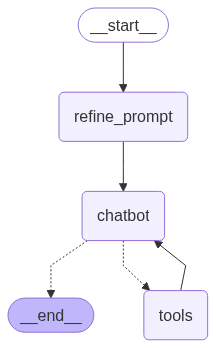

In [119]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [120]:
user_input = input("User: ")

events = graph.stream({"user_input": user_input}, stream_mode="updates")

In [121]:
for event in events:
    print(event)

{'refine_prompt': {'messages': [{'content': "You are a helpful assistant that manages a user's tasks.You have access to the tool: retrieve_tasks.For any requests made by the user for their tasks, you will use the retreive_tasks tool to get the task information.", 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'system', 'name': None, 'id': None}, {'content': 'Get all of my tasks.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': None}]}}
{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b', 'created_at': '2025-05-28T16:45:29.222854982Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1574279441, 'load_duration': 25577540, 'prompt_eval_count': 192, 'prompt_eval_duration': 210837431, 'eval_count': 22, 'eval_duration': 1335620898, 'model_name': 'llama3-groq-tool-use:8b'}, id='run--858ad3b4-7baf-4f4c-a6df-35b8217e9d6a-0', tool_calls=[{'name': 'retrieve_tasks', 'ar